# Tutorial 3 - Basis functions and kernel regression

Welcome to the third tutorial of the course 'Machine learning for Precision Medicine'.

In the last exercise we saw how we can predict Insulin level with regularized least squares linear regression (Ridge regression).

In this exercise we  predict an insurance cost (charge) of a patient, based on 6 other variables: age, sex, BMI, number of children, smoking, and geographical region. To do so, we will use basis functions for a non-linear kernel-regression model.

The dataset we are working with is from [kaggle](https://www.kaggle.com/mirichoi0218/insurance).
Of these variables, age, BMI and number of children are continuous, the rest are categorical.


In [1]:
# we will use the following packages for this exercise

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import assert_almost_equal

In [2]:
# load the data, and check out the first couple of rows
data = pd.read_csv('./insurance.csv', header=0)
data_orig = data
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Preprocessing
### One-hot encoding

We see that the variables sex, smoker and region are stored as strings. However, in order to be able to feed them to our machine learning algorithm, we will have to convert them to a numerical representation.

At a first glance it might seem intuitive to encode the variables in a way that assigns integers to the different kinds of values it can take. For example, we could replace every instance of "southwest" with 0, "southeast" with 1, "northeast" with 2 and "southwest" with 3 for the variable "region". However, this would imply an un-natural ordering that does not reflect any true relationship (southwest is not smaller than southeast).

Instead, we will create "dummy-variables" for each of these values. Again taking the variable "region" as an example, there will be a separate variable for each region, which we will call region_southwest, region_southeast, region_northwest and region_northeast. These variables will be 1 if we observed that region for the observation $\mathbf x$ and 0 otherwise.

We use the pandas function `pandas.get_dummies()` to convert the categorical variables to their one-hot representations.

In [3]:
list(data_orig.columns)

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [4]:
# 1-hot encoding for the categorical variables
data = pd.get_dummies(data, columns=['region','smoker','sex'])
print('old variables: {}'.format(list(data_orig.columns)))
print('new variables: {}'.format(list(data.columns)))

old variables: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
new variables: ['age', 'bmi', 'children', 'charges', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'smoker_no', 'smoker_yes', 'sex_female', 'sex_male']


Using `pd.get_dummies()` without `drop_first=True` leads to a redundant encoding. E.g. smoker_no and smoker_yes, which contain redundant information. We can drop one column for every original categorical variable without losing information:

(note that we could have also called `.get_dummies(...,drop_first=True)`)

In [5]:
# we get rid of the redundant columns:
data.drop(labels=['smoker_no','sex_male','region_northeast'], axis=1, inplace=True)
print('new variables: {}'.format(list(data.columns)))

new variables: ['age', 'bmi', 'children', 'charges', 'region_northwest', 'region_southeast', 'region_southwest', 'smoker_yes', 'sex_female']


We define our independent/dependent variables for the machine learning problem, and standardize them the same way as in the previous exercise. Note that here we apply zscore to our categorical variables too, this won't influence the result in this case. After standardizing, we will plot the distributions of variables and see how they are associated with cost (here: charges).

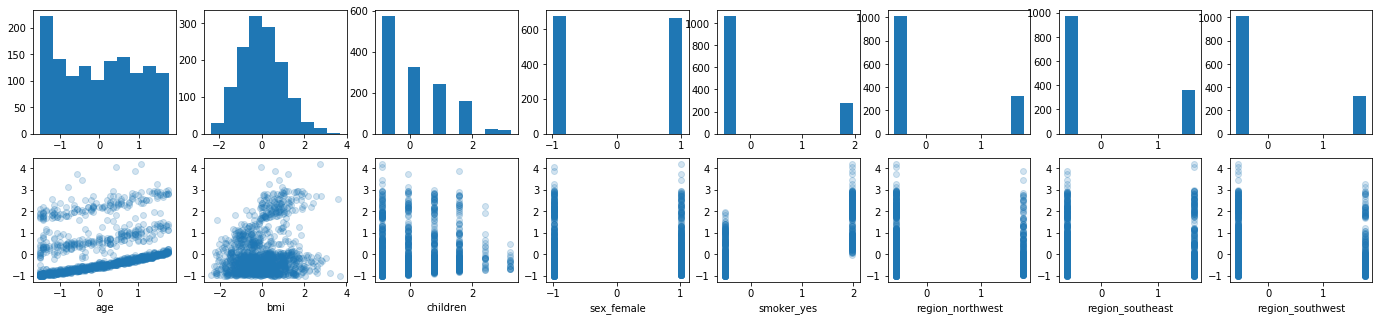

In [6]:
# Set dependent and independent variables 
dep_var = ['charges']
indep_var = ['age','bmi','children','sex_female','smoker_yes','region_northwest','region_southeast','region_southwest']

# standardize the data 
def zscore(x):
    return np.array((x - np.mean(x)) / (np.std(x)))

data = data.apply(zscore)

# Plot the distributions and see how the data is associated with cost (charges)
fig, ax = plt.subplots(2,len(indep_var),figsize=(24, 5))
for i, v in enumerate(indep_var):
    ax[0,i].hist(data[v])
    ax[0,i].set_xlabel('')
for i, v in enumerate(indep_var):
    ax[1,i].scatter(data[v],data[dep_var].values, alpha=0.2)
    ax[1,i].set_xlabel(v)

## Part 1: Ridge Regression
Before we start using basis functions or kernel regression, we want to get a baseline performance estimate of a Ridge regression model, the standardized data. Once we have the baseline, we aim at outperforming it by first using basis function transformations and then comparing it to a kernel regression model. 

Let's implement the Ridge regression model with the `Ridge` classifier from the scikit-learn package, just like we did in our last tutorial.

In [7]:
# define the training set
X = data[indep_var].values
y = data[dep_var].values

# split in to train, validation and test sets
# Train 60, Test 20, Valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

# we will perform hyper-parameter search over this range of values:
A = 10. ** np.linspace(start=3., stop=-6, num=100)

# we will use the root mean squared error to assess performance:
def rmse(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

## Task 1:
Implement a function `tune_ridge(X_train, y_train, X_valid, y_valid, A)`, that takes as input the training data (`X_train`, `y_train`), validation data (`X_valid`, `y_valid`) and a list of values `A` with different regularization parameters. In our last tutorial we used $\lambda$ to denote the regularization parameter as it is standard in textbooks. However, scikit-learn termed this parameter as $\alpha$. 

In oder to make things reproducible (i.e. get the correct **Expected Output**), initialize your Ridge-classifier as follows at every iteration:

```
model = Ridge(alpha=a, solver='lsqr', normalize=False)
```
Then calculate predictions and the error of your predictions for each $\alpha$. Then we want to get the best $\alpha$ according to the validation error. *hint: np.argmin()*


The function tune_ridge() should return 
- the training error (type: list) 
- validation error (type: list)
- the best value for the regularization parameter (type: float) 



In [8]:
def tune_ridge(X_train, y_train, X_valid, y_valid, A):
    # A is the list of values we want to use as our regularization parameter
  
    rmse_train=[]
    rmse_valid=[]  
  
    for a in A:
        #initialize your model and fit
        model = Ridge(alpha=a, solver='lsqr', normalize=False)
        model.fit(X_train, y_train)
  
        #get predictions with model.predict()
        y_pred_valid = model.predict(X_valid)
        y_pred_train = model.predict(X_train)
      
        #calculate the rmse with your function rmse() from above
        valid_error = rmse(y_valid,y_pred_valid)
        train_error = rmse(y_train, y_pred_train)
      
        #append() the calculated predictions and errors to rmse_train and rmse_valid
        rmse_train.append(train_error)
        rmse_valid.append(valid_error)
  
    #get the best alpha from A resulting in the minimum validation error. 
    best_a = A[np.argmin(rmse_valid)]
      
    return rmse_train, rmse_valid, best_a

In [9]:
# Call the ridge regression function above
rmse_train, rmse_valid, best_a = tune_ridge(X_train, y_train, X_valid, y_valid, A)

print('best alpha:       {}'.format(best_a))
print('validation error: {:.4f}'.format(np.min(rmse_valid)))
assert_almost_equal(best_a, 1e-06, 7, "best_a does not match expected value")
assert_almost_equal(np.min(rmse_valid), 0.4851, 4, "validation error does not match expected value")

best alpha:       1e-06
validation error: 0.4851


**Expected Output**:  
best alpha:       1e-06  
validation error: 0.4851

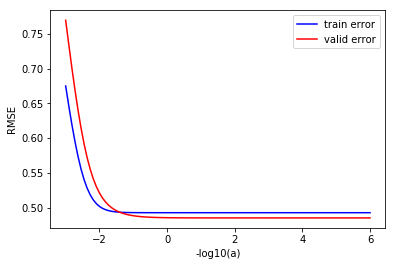

In [10]:
# Plot the train and validation performances
plt.plot(-1*np.log10(np.array(A)), rmse_train, '-b', label='train error')
plt.plot(-1*np.log10(np.array(A)), rmse_valid, '-r', label='valid error')
plt.xlabel('-log10(a)')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.show()

**Question 1**:  
Judging from the plot above, does your model seem to over-fit? (yes/no)

Why do you think this is the case? (1 sentence)

## Task 2:  

Write a function `evaluate_ridge()` that takes the training set (`X_train`, `y_train`), the test set (`X_test`, `y_test`) and one regularization parameter `a` as input. The function should initialize the model, fit the model and calculate the predicions and errors just like we did before.
At the end, the function should return the predictions on the test set and the corresponding root mean squared error. 



In [11]:
def evaluate_ridge(X_train, y_train, X_test, y_test, a):
  
    model = Ridge(alpha=a, solver='lsqr', normalize=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    error = rmse(y_test,y_pred)
  
    return y_pred, error

# we evaluate the function for the best value of a you found above
y_hat_test, error = evaluate_ridge(X_train, y_train, X_test, y_test, best_a)
print('test error: {:.4f}'.format(error))
assert_almost_equal(error, 0.5401, 4, "test error does not match expected value")

test error: 0.5401


**Expected Output:**  
test error: 0.5401

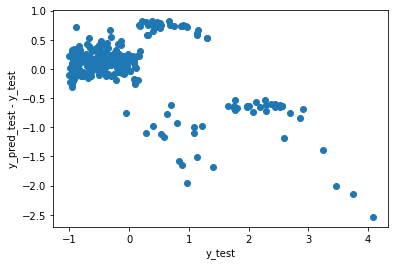

In [12]:
# we plot the residuals vs. y (true values)
plt.scatter(y_test, y_hat_test - y_test)
plt.xlabel('y_test')
plt.ylabel('y_pred_test - y_test')
plt.show()

## Part 2: Basis Functions

We hypothesize that there might be a non-linear dependency between cost (here: charge) and the input variables. 
To fit a model that non-lineary depends on our input variables, we need to transform our original input variables into an expanded feature space by computing a number of non-linear transformations.

For this exercise, you will implement the logistic sigmoid and the Gaussian (radial) basis functions (RBF).

The sigmoid basis function has the formula: 
$\phi \;(x) = \sigma\;(\frac{x-\mu}{s})$ , where $ \sigma\ (a) =  \frac{1}{1+e^{(-a)} } $ that means that $a = (\frac{x-\mu}{s})$


The Gaussian radial basis (RBF) function has the formula:
$\phi\; (x) = exp\;(-\frac{(x-\mu)^2}{2s^2})$


## Task 3:

Implement the function `sigmoid(x, mu, s)` 

Implement the function `rbf(x, mu, s)` which both take 3 arguments: 

x:  the value of x which should be transformed (np.ndarray)  
mu: $\mu$  (float)  
s:  $s$ (float) 

In [13]:
def sigmoid(x, mu, s):
    a = (x - mu) / s
    sig = 1 / (1+ np.e**(-a))
    return sig

def rbf(x, mu, s):
    r = np.exp (- ((x - mu) ** 2) / (2 * (s** 2)))
    return r

In [14]:
sigmoids = [sigmoid(0.5,1,0.5),sigmoid(1.,1.,0.5),sigmoid(3.,1.,0.5)]
gaussians = [rbf(0.5,1,0.5),rbf(1,1,0.5),rbf(3,1,0.5)]
print('Sigmoid :\n{:.2f}\t{:.2f}\t{:.2f}'.format(*sigmoids))
print('Gaussian:\n{:.2f}\t{:.2f}\t{:.2f}'.format(*gaussians))
assert_almost_equal(sigmoids, [0.27, 0.50, 0.98], 2, "sigmoids do not match expected values")
assert_almost_equal(gaussians, [0.61, 1.00, 0.00], 2, "gaussians do not match expected values")


Sigmoid :
0.27	0.50	0.98
Gaussian:
0.61	1.00	0.00


** Expected Output:**  
Sigmoid :  
0.27	0.50	0.98  
Gaussian:  
0.61	1.00	0.00  


Now, we generate 100 values from -2 to 2 and pass them into our sigmoid function with four different values for mu and s respectively. 

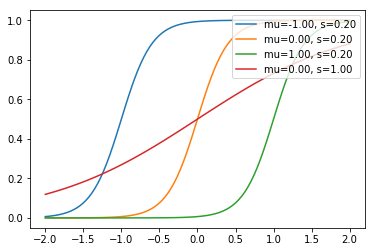

In [15]:
#Plotting function
def plot_transform(x, mu, s, fun):
    
    for i in range(len(mu)):
        plt.plot(x, fun(x, s=s[i], mu=mu[i]), label='mu={:.2f}, s={:.2f}'.format(mu[i], s[i]))
        
    plt.legend(loc='upper right')
    plt.show()

#Call for sigmoid function
plot_transform(np.linspace(-2,2,num=100), mu=[-1,0,1,0], s=[0.2, 0.2, 0.2, 1.], fun=sigmoid)

Now, we generate 100 values from -2 to 2 and pass them into our 4 different RBF functions with different values for mu and s. 

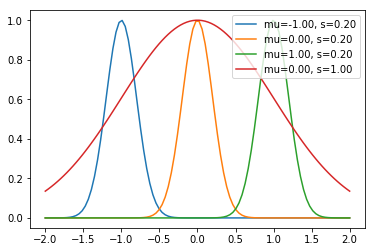

In [16]:
#Call for rbf function
plot_transform(np.linspace(-2,2,num=100), mu=[-1,0,1,0], s=[0.2, 0.2, 0.2, 1.], fun=rbf)

** Question 2 **:  
What do the mu and s parameters control for the sigmoid and the Gaussian basis functions?


mu: location of basis functions in input space
s: governs spacial scale of basis functions
Mu controls the mean so translation on the x axis, while s controls the steepness or spread (variance).

Below we've implemented a function `transform_data(df, cols, M, S, func)` that allows you to compute transformations of your input variables using the basis functions which you implemented above, where:

```
df :   dataframe containing your variables
cols:  list of columns you want to be transformed
M:     an array of values you want to use for mu
S:     an array of values you want to use for s
func:  one of the functions you implemented above, either sigmoid or rbf
```

For every column in `cols` corresponding to one independent variable, it will calculate transformed variables using the basis function `func`. A total of `len(M) * len(S)` transformations will be calculated for each variable in `cols` (all combinations), leading to a total of `len(cols) * len(M) * len(S)` variables.

We've also initialized the two example arrays `M` and `S` for you. But you can try different values if you want.

In [17]:
def transform_data(df, cols, M, S, func):
    
    n_var = len(cols) * len(M) * len(S)
    
    if n_var > 100000:
        raise Exception("You tried to calculate more than 100000 variables. Maybe try a bit less...")
        
    data_transform = { '{}_m{}_s{}'.format(col, m, s):  func(data[col].values, m, s) for col in cols for m in M for s in S}
    return pd.DataFrame.from_dict(data_transform)

M = np.linspace(-4, 4, num=100)
S = np.array([5.,2.,1.,0.5,0.25,0.1,0.01])

## Task 4: 
Pick the basis function you want to use, replace `#your_code` with `sigmoid` or `rbf`

In [18]:
# feel free to replace M and S with your own values and play around, or use the default we gave above:
M = M
S = S

func = sigmoid

data_transform = transform_data(data, indep_var, M, S, func)

print( 'number of basis functions: {}'.format(len(M)*len(S)))
print( 'data_transform.shape:      {}'.format(data_transform.shape ))

number of basis functions: 700
data_transform.shape:      (1338, 5600)


Now that we transformed the original independent variables with our function of choice, we can perform a regression on our set of transformed variables. 

In [19]:
# define the training set again:
X = data_transform.values
y = data[dep_var].values

# split in to train, validation and test sets (we use the same random state as above)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

# different values for alpha
A = 10. ** np.linspace(start=4., stop=-6, num=100)

# fit the model:
# depending on how you picked the parameters above, this could be a bit slow
rmse_train, rmse_valid, best_a = tune_ridge(X_train, y_train, X_valid, y_valid, A)

print('best alpha:       {}'.format(best_a))
print('validation error: {:.4f}'.format(np.min(rmse_valid)))

best alpha:       59.94842503189409
validation error: 0.4759


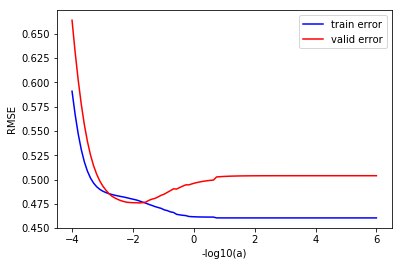

In [20]:
# we plot the train and validation performances
plt.plot(-1*np.log10(np.array(A)), rmse_train, '-b', label='train error')
plt.plot(-1*np.log10(np.array(A)), rmse_valid, '-r', label='valid error')
plt.xlabel('-log10(a)')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
plt.show()

In [21]:
# we evaluate the function for the best value of 'a' you found above
y_hat_test, error = evaluate_ridge(X_train, y_train, X_test, y_test, best_a)
y_hat_basis_function = y_hat_test

print('test error: {:.4f}'.format(error))

test error: 0.5333


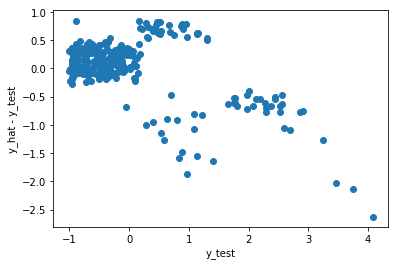

In [22]:
# we plot the residuals vs. y
plt.scatter(y_test, y_hat_test - y_test)
plt.xlabel('y_test')
plt.ylabel('y_hat - y_test')
plt.show()

### Discussion:
You may have noticed that the test-error improved a (tiny) bit by using the transformed variables above, and that it may have taken quite some time to run the parameter tuning step (search for optimal a). If we wanted to find optimal transformations for our variables, we would have to perform an extensive (and computationally expensive) parameter search over different sets of parameters for our basis functions.

We will not go down this path. Instead, in the second part of this exercise, we will show you how to perform kernel regression, which can save us the effort of calculating additional features explicitly.

## Part 3:  Kernel Regression

Kernel regression is equivalent to solving the dual problem of least squares regression.

It involves calculating a kernel matrix $\mathbf K$, with dimensions $n*n$, where $n$ is the number of observations. $\mathbf K$ can be thought of as a similarity matrix between the observations. 

We will implement kernel regression here for the linear kernel and the RBF kernel. We will use the scikit-learn module to calculate the kernel matrix $\mathbf K$ for the RBF kernel.

Whereas we looked for a parameter vector $\mathbf θ$ in ridge regression before , we now look for $\mathbf a$. 


In [23]:
# we go back to our original variables:
X = data[indep_var].values
y = data[dep_var].values

# split in to train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

## Task 5:

Implement the formula below. Write a function `get_a(K,lambd,y)` that takes a kernel matrix `K` (numpy.ndarray), regularization parameter `lambd` (float, corresponds to $\lambda$) and a vector of target values `y`, and returns the dual variable vector `a`. 

$$ \mathbf a = (\mathbf K + \lambda \mathbf I)^{-1}\mathbf y$$

hint: np.linalg.inv(), np.eye(), dot() 

In [24]:
def get_a(K, lambd, y):
    return np.linalg.inv(K + lambd * np.eye(len(K))).dot(y)

## Task 6:

In the lecture we discussed that the kernel matrix is defined as the matrix product of $\mathbf Φ$ with it's transpose $\mathbf Φ^{T}$. In case of the linear kernel, our basis function $f(x)$ is simply $x$, which means that $\mathbf Φ = \mathbf X$ 

The formula for the linear kernel is therefore:
$$K_{linear} = \mathbf{X}\mathbf{X^T}$$

Compute the kernel matrix `K_linear`, for the data matrix `X_train`:

In [25]:
#Student version

K_linear = np.dot(X_train, np.transpose(X_train))

print('shape:     {}'.format(K_linear.shape))
print('a1: {}'.format(get_a(K_linear, 0.01, y_train)[0]))
assert_almost_equal(K_linear.shape, (802, 802), 1, "shape does not match expected value")
assert_almost_equal(get_a(K_linear, 0.01, y_train)[0], [-6.00066083] , 8, "al does not match expected value")

shape:     (802, 802)
a1: [-6.00066083]


**Expected Output:**  
shape: (802, 802)  
a1: [-6.00066083] 

In [26]:
# for the RBF-kernel, we use the sklearn.metrics.pairwise_kernels function:
from sklearn.metrics.pairwise import pairwise_kernels
K_rbf = pairwise_kernels(X_train, metric='rbf')

The RBF Kernel of two samples x and x' is defined as $$K(\mathbf{x},\mathbf{x'}) = exp(-\frac{\lVert \mathbf{x}-\mathbf{x'} \rVert^2}{2s^2}) $$

**Question 3:**  
How does the function behave, if x and x' are very similar or different?

If $x$ and $x'$ are similar the function will get close to 1. If they differ it well be below 1.


In order to predict $y$ for new observations, we have to calculate the pairwise kernel between the new observations and the original observations. The kernel vector $k(x^*)$ is defined as the vector of inner $k(x^*, x_N )$ products of $\mathbf Φ(x^*)$ with all training data points in matrix $\mathbf Φ$.

## Task 7:
Now we will perform a kernel regression, by writing a function 'tune_kernel_regression' (similar to `tune_ridge` above), which takes the training and validation sets, the lambda-vector L and the desired metric as input.

In the function we will use the `pairwise_kernels` function from the scikit-learn module to calculate the kernel as explained above. "metric" is passed to the `pairwise_kernels` function and defines which kernel we want to use. Look up the documentation of this function and explore the different input parameters. 

As we did for Ridge regression above, we will loop over different values for $\lambda$, stored in a vector L, calculate the dual variable a by calling the get_a() function we implemented before. 

Then we calculate the predicted y (y_hat) for our training and validation set using the specified kernel. Note that our training data was used to compute the kernel matrix ($\mathbf K$), therefore we can just use the original kernel matrix to compute the predictions on the training data. For new unseen data, we need to compute the pairwise kernel matrix `k_xstar` between the new and original observations. 

We will then evaluate the regression performances on the training and validation set for each lamda using the rmse and select the best parameter with the smallest validation error. 

Again, the function should return `rmse_train`, `rmse_valid`, and `best_lambd` (the value for lambda which had the lowest validation error). 


In [27]:
def tune_kernel_regression(X_train, y_train, X_valid, y_valid, L, metric='linear'):
    
    rmse_train = []
    rmse_valid = []
    
    K = pairwise_kernels(X_train, metric=metric)
    
    for lambd in L:
        a = get_a(K, lambd, y_train)  
        k_xstar = pairwise_kernels(X_valid, X_train, metric=metric)
        y_hat_train = K.T.dot(a)
        y_hat_valid = k_xstar.dot(a)
        
        train_err = rmse(y_train, y_hat_train)
        valid_err = rmse(y_valid, y_hat_valid)
        
        rmse_train.append(train_err)
        rmse_valid.append(valid_err)
    
    best_lambd = L[np.argmin(rmse_valid)]
    
    return rmse_train, rmse_valid, best_lambd


In [28]:
# we define the range of lambda-values to loop over:
L = 10. ** np.linspace(start=3., stop=-4, num=100)

# and calculate the errors of the kernel regression models
res_Klin = tune_kernel_regression(X_train, y_train, X_valid, y_valid, L, metric='linear')
res_Krbf = tune_kernel_regression(X_train, y_train, X_valid, y_valid, L, metric='rbf')

Let's look at the performance of the linear kernel over all lambdas:

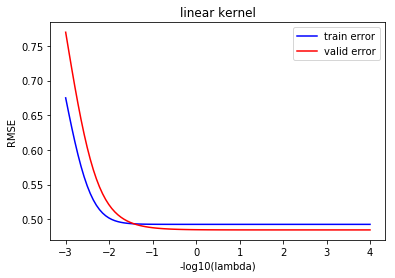

In [29]:
# we plot the train and validation performances
plt.plot(-1*np.log10(np.array(L)), res_Klin[0], '-b', label='train error')
plt.plot(-1*np.log10(np.array(L)), res_Klin[1], '-r', label='valid error')
plt.xlabel('-log10(lambda)')
plt.ylabel('RMSE')
plt.title('linear kernel')
plt.legend(loc='upper right')
plt.show()

... And the performance of the RBF kernel

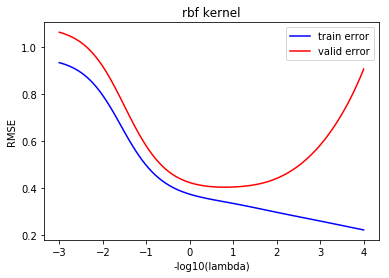

In [30]:
# we plot the train and validation performances
plt.plot(-1*np.log10(np.array(L)), res_Krbf[0], '-b', label='train error')
plt.plot(-1*np.log10(np.array(L)), res_Krbf[1], '-r', label='valid error')
plt.xlabel('-log10(lambda)')
plt.ylabel('RMSE')
plt.title('rbf kernel')
plt.legend(loc='upper right')
plt.show()

And now, let's compare the rmses on the validation sets from linear and RBF kernels

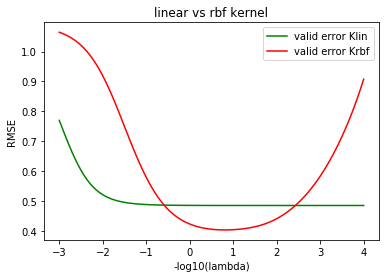

In [31]:
# we plot the train and validation performances
plt.plot(-1*np.log10(np.array(L)), res_Klin[1], '-g', label='valid error Klin')
plt.plot(-1*np.log10(np.array(L)), res_Krbf[1], '-r', label='valid error Krbf')
plt.xlabel('-log10(lambda)')
plt.ylabel('RMSE')
plt.title('linear vs rbf kernel')
plt.legend(loc='upper right')
plt.show()

Now we evaluate the kernel regression with the best lambda, that we got from the tune_kernel_regression()-output. We write basically the same function as above, but for only one value of lambd.

In [32]:
# we've already written the evaluation function for you:
def evaluate_kernel_regression(X_train, y_train, X_test, y_test, best_lambd, metric='linear'):
    
    K = pairwise_kernels(X_train, metric=metric)
    a = get_a(K, best_lambd, y_train)
    
    y_hat = pairwise_kernels(X_test,X_train,metric=metric).dot(a)
    
    error = rmse(y_test, y_hat)
    
    return y_hat, error


# we evaluate the function for the best value of a that you you found above
eval_Klin = evaluate_kernel_regression(X_train, y_train, X_test, y_test, res_Klin[2], metric='linear')
eval_Krbf = evaluate_kernel_regression(X_train, y_train, X_test, y_test, res_Krbf[2], metric='rbf')

print('test error linear kernel: {:.4f}'.format(eval_Klin[1]))
print('test error rbf kernel:    {:.4f}'.format(eval_Krbf[1]))
assert_almost_equal(eval_Klin[1], 0.5401, 4, "Test error of linear kernel does not match expected value!")
assert_almost_equal(eval_Krbf[1], 0.4403, 4, "Test error of rbf kernel does not match expected value!")

test error linear kernel: 0.5401
test error rbf kernel:    0.4403


**Question 4:**
Look at the performance graphs and test errors above. What can you say about the performances of linear and rbf kernel regressions? Which one performed better?

The RBF kernel regression performs better, it has a lower test error with the optimal lambda than the regression with the linear kernel.
In addition the RBF kernel performs well enough to overfit. This means that the RBF kernel fits the training data well enough, that it can be represented with it. Although we don't want the algorithm to overfit, it is an encouraging sign, that overfitting is possible.

Success! we have finally managed to improve performance compared to the original linear model!

Feel free to try out other kernels as well and see what happens. 

Look at the residual plot below and see how the points have shifted.

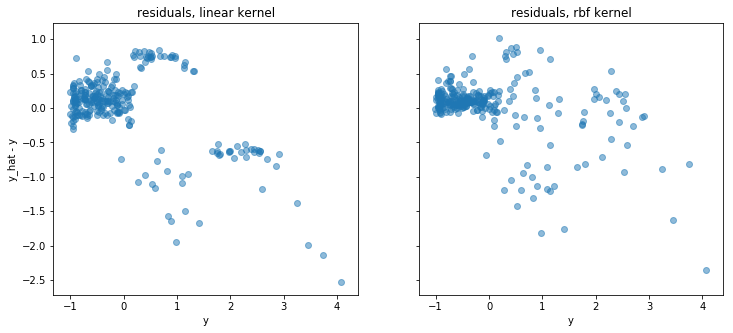

In [33]:
# we plot the residuals vs y
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12, 5))
ax[0].scatter(y_test, eval_Klin[0] - y_test, alpha=0.5)
ax[0].set_title('residuals, linear kernel')
ax[0].set_ylabel('y_hat - y')
ax[0].set_xlabel('y')
ax[1].scatter(y_test, eval_Krbf[0] - y_test, alpha=0.5)
ax[1].set_title('residuals, rbf kernel')
ax[1].set_xlabel('y')
plt.show()